In [1]:
import os
import torch
import splitfolders
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

%matplotlib inline

from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
input_dir = "Lab1\simpsons_dataset"
PATH = "Lab1\data"

#splitfolders.ratio(input_dir, output=PATH,seed=1332, ratio=(.6, 0.2,0.2))

image_size = (64, 64, 3)
epochs = 20
classes = os.listdir(input_dir)
print(len(classes))
print((classes))

20
['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz']


In [3]:
def image_shower(images, labels, n):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image / 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%6s' % classes[label] for label in labels[:n]))
    
transform = transforms.Compose(
    [transforms.Resize((32,32)), 
     transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"),
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=100,
                                          num_workers=0,
                                          shuffle=True)


valset = torchvision.datasets.ImageFolder(os.path.join(PATH, "val"),
                                           transform=transform)
valloader = torch.utils.data.DataLoader(valset,
                                         batch_size=50,
                                         num_workers=0,
                                         shuffle=True)


testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"),
                                           transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=50,
                                         num_workers=0,
                                         shuffle=True)


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net2 = Net2()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr = 0.001, momentum=0.9)

In [8]:
train_losses = []
val_losses= []

for epoch in range(epochs):
    train_loss, val_loss, correct_train, correct_val = 0, 0, 0, 0
    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        prediction = outputs.max(dim=1, keepdim=True)[1]
        correct_train += prediction.eq(labels.view_as(prediction)).sum()
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(valloader, 0)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            prediction = outputs.max(dim=1, keepdim=True)[1]
            correct_val += prediction.eq(labels.view_as(prediction)).sum()

    train_loss/=len(trainloader)
    val_loss/=len(valloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    
    print ("Epoch {} - Train loss: {} ".format(epoch+1, train_loss))
    print ("Epoch {} - Val loss: {} ".format(epoch+1, val_loss))

132it [01:47,  1.23it/s]
84it [00:35,  2.37it/s]


Epoch 1 - Train loss: 3.7187467777367793 
Epoch 1 - Val loss: 3.6796523190680004 


132it [01:52,  1.17it/s]
84it [00:35,  2.39it/s]


Epoch 2 - Train loss: 3.5814471768610403 
Epoch 2 - Val loss: 3.3138274323372614 


132it [01:50,  1.19it/s]
84it [00:35,  2.35it/s]


Epoch 3 - Train loss: 3.2422337983593796 
Epoch 3 - Val loss: 3.1069627148764476 


132it [01:50,  1.19it/s]
84it [00:35,  2.34it/s]


Epoch 4 - Train loss: 3.1897654858502476 
Epoch 4 - Val loss: 3.065515418847402 


132it [01:49,  1.20it/s]
84it [00:35,  2.37it/s]


Epoch 5 - Train loss: 3.127616161649877 
Epoch 5 - Val loss: 2.9884319674401056 


132it [01:50,  1.19it/s]
84it [00:35,  2.35it/s]


Epoch 6 - Train loss: 3.053649972785603 
Epoch 6 - Val loss: 2.887164885089511 


132it [01:52,  1.17it/s]
84it [00:35,  2.39it/s]


Epoch 7 - Train loss: 2.932013867479382 
Epoch 7 - Val loss: 2.788803214118594 


132it [01:48,  1.21it/s]
84it [00:35,  2.38it/s]


Epoch 8 - Train loss: 2.8283661766485735 
Epoch 8 - Val loss: 2.687695270492917 


132it [01:47,  1.23it/s]
84it [00:35,  2.39it/s]


Epoch 9 - Train loss: 2.735487921671434 
Epoch 9 - Val loss: 2.6353130539258323 


132it [01:39,  1.32it/s]
84it [00:34,  2.45it/s]


Epoch 10 - Train loss: 2.6581214846986714 
Epoch 10 - Val loss: 2.6201387615430924 


132it [01:51,  1.19it/s]
84it [00:35,  2.37it/s]


Epoch 11 - Train loss: 2.6021486033092844 
Epoch 11 - Val loss: 2.5281267648651484 


132it [01:51,  1.18it/s]
84it [00:22,  3.77it/s]


Epoch 12 - Train loss: 2.534730665611498 
Epoch 12 - Val loss: 2.45394218819482 


132it [00:46,  2.86it/s]
84it [00:13,  6.14it/s]


Epoch 13 - Train loss: 2.446616302837025 
Epoch 13 - Val loss: 2.4131309929348173 


132it [00:47,  2.77it/s]
84it [00:13,  6.26it/s]


Epoch 14 - Train loss: 2.3843744695186615 
Epoch 14 - Val loss: 2.45020407580194 


132it [00:48,  2.74it/s]
84it [00:13,  6.13it/s]


Epoch 15 - Train loss: 2.3476554597869064 
Epoch 15 - Val loss: 2.3811956629866646 


132it [00:47,  2.76it/s]
84it [00:13,  6.19it/s]


Epoch 16 - Train loss: 2.318070807691776 
Epoch 16 - Val loss: 2.2752632129760015 


132it [00:49,  2.68it/s]
84it [00:14,  5.61it/s]


Epoch 17 - Train loss: 2.2502247004797966 
Epoch 17 - Val loss: 2.326678684779576 


132it [01:38,  1.34it/s]
84it [00:35,  2.39it/s]


Epoch 18 - Train loss: 2.314622844258944 
Epoch 18 - Val loss: 2.215867357594626 


132it [01:46,  1.23it/s]
84it [00:35,  2.35it/s]


Epoch 19 - Train loss: 2.1632538564277417 
Epoch 19 - Val loss: 2.1951999011493863 


132it [01:47,  1.23it/s]
84it [00:34,  2.44it/s]

Epoch 20 - Train loss: 2.123602863514062 
Epoch 20 - Val loss: 2.282552039339429 


In [9]:
train_losses2 = []
val_losses2= []

for epoch in range(epochs):
    train_loss2, val_loss2, correct_train2, correct_val2 = 0, 0, 0, 0
    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer2.zero_grad()
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()
        train_loss2 += loss.item()
        prediction = outputs.max(dim=1, keepdim=True)[1]
        correct_train2 += prediction.eq(labels.view_as(prediction)).sum()
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(valloader, 0)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net2(inputs)
            loss = criterion(outputs, labels)
            val_loss2 += loss.item()
            prediction = outputs.max(dim=1, keepdim=True)[1]
            correct_val2 += prediction.eq(labels.view_as(prediction)).sum()

    train_loss2/=len(trainloader)
    val_loss2/=len(valloader)
    train_losses2.append(train_loss2)
    val_losses2.append(val_loss2)

    
    print ("Epoch {} - Train loss: {} ".format(epoch+1, train_loss2))
    print ("Epoch {} - Val loss: {} ".format(epoch+1, val_loss2))

132it [01:46,  1.24it/s]
84it [00:36,  2.32it/s]


Epoch 1 - Train loss: 3.7137287692590193 
Epoch 1 - Val loss: 3.6519285922958735 


132it [01:48,  1.22it/s]
84it [00:36,  2.31it/s]


Epoch 2 - Train loss: 3.552606082323826 
Epoch 2 - Val loss: 3.414074948855809 


132it [01:48,  1.22it/s]
84it [00:35,  2.39it/s]


Epoch 3 - Train loss: 3.3813239859812185 
Epoch 3 - Val loss: 3.261019445600964 


132it [01:47,  1.23it/s]
84it [00:35,  2.38it/s]


Epoch 4 - Train loss: 3.316114944038969 
Epoch 4 - Val loss: 3.2210462320418585 


132it [01:47,  1.23it/s]
84it [00:36,  2.29it/s]


Epoch 5 - Train loss: 3.287300633661675 
Epoch 5 - Val loss: 3.2083203480357216 


132it [01:49,  1.21it/s]
84it [00:36,  2.28it/s]


Epoch 6 - Train loss: 3.2676852056474397 
Epoch 6 - Val loss: 3.187122725305103 


132it [01:47,  1.23it/s]
84it [00:35,  2.34it/s]


Epoch 7 - Train loss: 3.262321914687301 
Epoch 7 - Val loss: 3.1727754331770397 


132it [01:53,  1.17it/s]
84it [00:35,  2.37it/s]


Epoch 8 - Train loss: 3.2782366384159434 
Epoch 8 - Val loss: 3.1654091959907893 


132it [01:49,  1.21it/s]
84it [00:35,  2.34it/s]


Epoch 9 - Train loss: 3.235124246640639 
Epoch 9 - Val loss: 3.1286405665533885 


132it [01:51,  1.19it/s]
84it [00:36,  2.29it/s]


Epoch 10 - Train loss: 3.220831309304093 
Epoch 10 - Val loss: 3.1092720854850042 


132it [01:51,  1.18it/s]
84it [00:36,  2.32it/s]


Epoch 11 - Train loss: 3.1933005090915794 
Epoch 11 - Val loss: 3.0737063941501437 


132it [01:52,  1.18it/s]
84it [00:35,  2.34it/s]


Epoch 12 - Train loss: 3.133146373611508 
Epoch 12 - Val loss: 3.0343104061626254 


132it [01:52,  1.18it/s]
84it [00:35,  2.34it/s]


Epoch 13 - Train loss: 3.0937579292239565 
Epoch 13 - Val loss: 2.986343673297337 


132it [01:46,  1.24it/s]
84it [00:34,  2.45it/s]


Epoch 14 - Train loss: 3.054862282492898 
Epoch 14 - Val loss: 2.9378400388218107 


132it [01:41,  1.30it/s]
84it [00:34,  2.45it/s]


Epoch 15 - Train loss: 3.029128499103315 
Epoch 15 - Val loss: 2.9131321821893965 


132it [01:37,  1.35it/s]
84it [00:33,  2.49it/s]


Epoch 16 - Train loss: 2.990420556429661 
Epoch 16 - Val loss: 2.88686736424764 


132it [01:39,  1.33it/s]
84it [00:33,  2.49it/s]


Epoch 17 - Train loss: 2.949290293635744 
Epoch 17 - Val loss: 2.8366508171671914 


132it [01:37,  1.35it/s]
84it [00:34,  2.46it/s]


Epoch 18 - Train loss: 2.902809059981144 
Epoch 18 - Val loss: 2.8148964444796243 


132it [01:36,  1.37it/s]
84it [00:33,  2.48it/s]


Epoch 19 - Train loss: 2.8718970454100408 
Epoch 19 - Val loss: 2.777979944433485 


132it [01:39,  1.33it/s]
84it [00:34,  2.45it/s]

Epoch 20 - Train loss: 2.8598566597158257 
Epoch 20 - Val loss: 2.753254697436378 


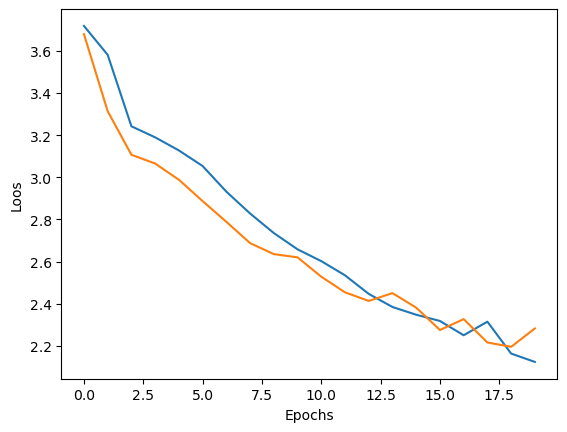

In [10]:
plt.plot([i for i in range(0, epochs)], train_losses) #without drop
plt.plot([i for i in range(0, epochs)], val_losses)
plt.ylabel('Loos')
plt.xlabel('Epochs')
plt.show()

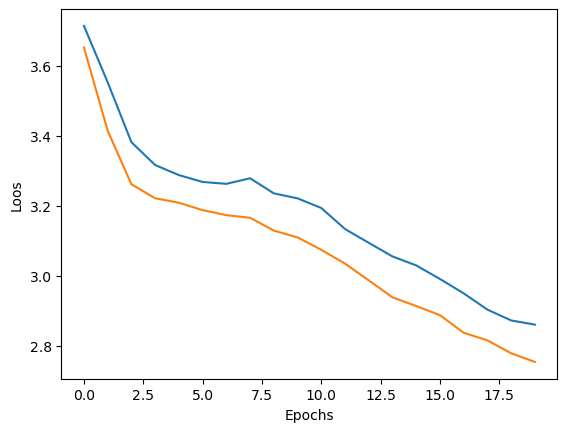

In [22]:
plt.plot([i for i in range(0, epochs)], train_losses2) #с
plt.plot([i for i in range(0, epochs)], val_losses2) #о
plt.ylabel('Loos')
plt.xlabel('Epochs')
plt.show()